In [2]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
#from scipy.integrate import odeint
import numpy as np
import pandas as pd
#from sklearn.metrics import r2_score
from tensorflow import keras
#from skopt.space import Space
#from eml.net.reader import keras_reader

from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

# Specify data folder
data_folder = '/app/data'

# Load the dataset
data_sv_dict = util.split_by_field(util.load_cmapss_data(data_folder), field='src')
data = data_sv_dict['train_FD004']
# Define input folders
dt_in = list(data.columns[3:-1])
# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = data.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]
# Split datasets
tr, ts = util.partition_by_machine(data, tr_mcn)
# Rescale
tr_s, ts_s, nparams = util.rescale_CMAPSS(tr, ts)

# Load pre-trained model
nn = keras.models.load_model("rul_classifier")

# Last step for prediction plots
stop = 1400
# Define the cost model
tr_failtimes = tr.groupby('machine')['cycle'].max()
safe_interval = tr_failtimes.min()
maintenance_cost = tr_failtimes.max()
cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)

# Evaluation
tr_pred = np.round(nn.predict(tr_s[dt_in]).ravel())
ts_pred = np.round(nn.predict(ts_s[dt_in]).ravel())
tr_c, tr_f, tr_sl = cmodel.cost(tr['machine'].values, tr_pred, 0.5, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, 0.5, return_margin=True)


# Let's redo some work
f = lambda x: 1/(1+x) * np.sin(6 * np.pi * x) + x**2
x = np.linspace(0, 1, 10000)
target = pd.Series(index=x, data=f(x))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Bayesian Optimization from Scratch

...Just use a library for real-world applications, ok?

## Decisions, Decisions, Decisions

**Our psuedo-code is implemented in `simple_univariate_BO`**

* $\text{$x^*  = $ the current candidate optimum}$
* $\text{while $i = 1..n_{it}$:}$
  - $x^\prime = \text{argmax}_x \{ g(x) \mid l \leq x \leq u, \tilde{f}(x) < f(x^*) \}$ # Find candidate
  - $\text{if no such $x^\prime$ exists, then return $x^*$}$
  - $\text{If $f(x^\prime) < f(x^*)$ , then $x^* = x^\prime$}$ 
  - $\text{update $\tilde{f}$}$ # Refine the surrogate model

**In the implementation, a few key choices were made:**

* How to pick the initial candidate optimum?
* Which surrogate model to use?
* How to optimize over the surrogate?
* Which acquisition function $g$ to use?

## Initial Candidate

**It is common to initialize BO by _sampling_ a few solutions**

* This can be done uniformly at random
* ...Or we can use smarter approach

We sue the simplest approach, i.e.:

* (Uniform) Random sampling to obtain a few evaluations

```python
X = np.random.uniform(l, u, size=(init_points, 1))
y = f(X)
```

* Then just pick the best point as a candidate optimum

```python
best_idx = int(np.argmin(y))
best_x = X[best_idx]
best_y = X[best_idx]
```

## Surrogate and Optimization Strategy

**As a surrogate, we use a _Gaussian Process_**

As a kernel we use a RBF + noise combination:

```python
kernel = RBF(1, (1e-6, 1e0)) + WhiteKernel(1, (min_noise, 1e0))
```

* The first kernel parameters are initial guessesfor gradient descent
* The second parameters are bounds for the training process

**For the optimization part, we use _grid search_**

* ...Since we are doing only univariate optimization
* ...And evaluating the surrogate model is fast enough

In practice, we define a _fixed_ grid of points to be be evaluated:

```python
x = np.linspace(l, u, n_samples_gs)
```

## Starting Situation

**Let's start with a pool of 5 randomly sampled points**

* The candidate optimum is the sample with the lower $f$
* The GP model estimates $\mu$ and $\sigma$ for all points in our optimization grid

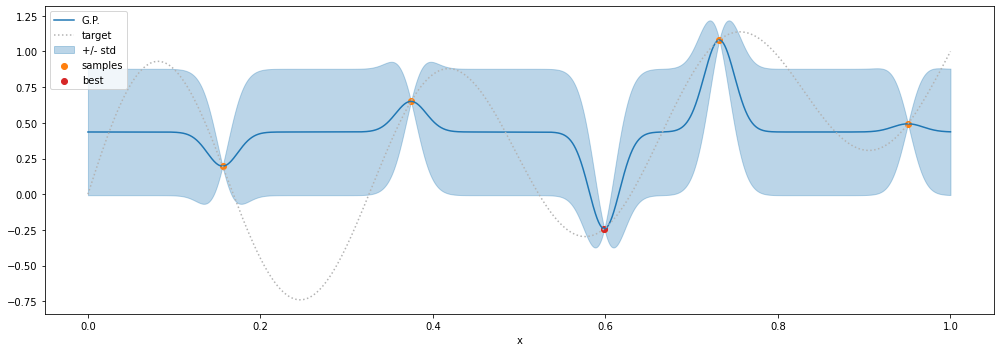

In [3]:
sol, state = util.simple_univariate_BO(f, 0, 1, init_points=5, max_it=0, seed=42, return_state=True, suppress_warnings=True)
util.plot_series(state['mu'], samples=state['samples'], std=state['std'], target=target, samples2=state['sopt'], samples2_lbl='best', figsize=figsize, xlabel='x', ylabel='G.P.')

## Acquisition Function

**Finally, we need to pick an _acquisition function_**

* A good acquisition function should balance _exploration_ and _exploitation_
* Let's examine a few common choices

**Probability of improvement**

This is defined as the estimated _probability_ of obtaining an improvement:

$$
a_{PI}(x) = \mathbb{E}[\mathbb{1}_{f(x) \leq y^*}] = \int_{-\infty}^{y^*} \phi(y, \mu_{f(x)}, \sigma_{f(x)}) dy = \\
\Phi(y^*, \mu_{f(x)}, \sigma_{f(x)})
$$

* PRO: clear interpretation
* CON: does not account for the magnitude of improvement

## Acquisition Function

**Finally, we need to pick an _acquisition function_**

* A good acquisition function should balance _exploration_ and _exploitation_
* Let's examine a few common choices

**Expected improvement**

This is defined as the expected value of the improvement itself:

$$
a_{EI}(x) = \mathbb{E}[\max(0, y^* - f(x))] = \int_{-\infty}^{y^*} (y^* - y) \phi(y, \mu_{f(x)}, \sigma_{f(x)}) dy = \\
(y^* - \mu_{f(x)}) \Phi(y^*, \mu_{f(x)}, \sigma_{f(x)}) + \sigma_{f(x)} \phi(y^*, \mu_{f(x)}, \sigma_{f(x)})
$$

* PRO: accounts for exploitation (via the first term)
* PRO: accounts for exploration (via the second term)
* CON: the trade-off between the two cannot be controlled

## Acquisition Function

**Finally, we need to pick an _acquisition function_**

* A good acquisition function should balance _exploration_ and _exploitation_
* Let's examine a few common choices

**Lower Confidence Bound**

This is the lower bound of a given confidence interval

$$
a_{LCB}(x) = \mu_{f(x)} - Z_{\alpha} \sigma_{f(x)}
$$

Where $Z_{\alpha}$ is the coefficient needed to get the $\alpha\%$ confidence interval

* PRO: accounts for exploitation and exploration
* PRO: the trade-off can be controlled
* CON: the trade-off needs to be controlled :-)

## Experiments: Probability of Improvement

**Let's try to iterate once using $a_{PI}$ as acquisition function**

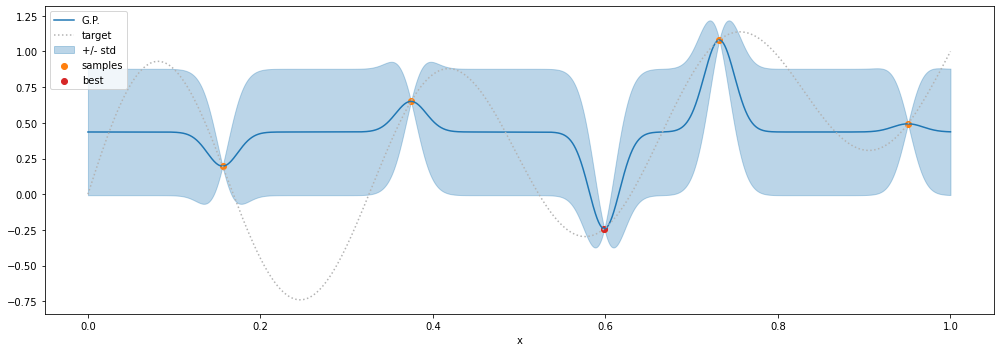

In [4]:
sol, state = util.simple_univariate_BO(f, 0, 1, init_points=5, max_it=1, seed=42, ftype='pi', return_state=True, suppress_warnings=True)
util.plot_series(state['mu'], samples=state['samples'], std=state['std'], target=target, samples2=state['sopt'], samples2_lbl='best', figsize=figsize, xlabel='x', ylabel='G.P.')

* The new points is _very_ close to the initial candidate optimum
* ...And it also improves on its value

## Experiments: Probability of Improvement

**Let's try to iterate once using $a_{PI}$ as acquisition function**

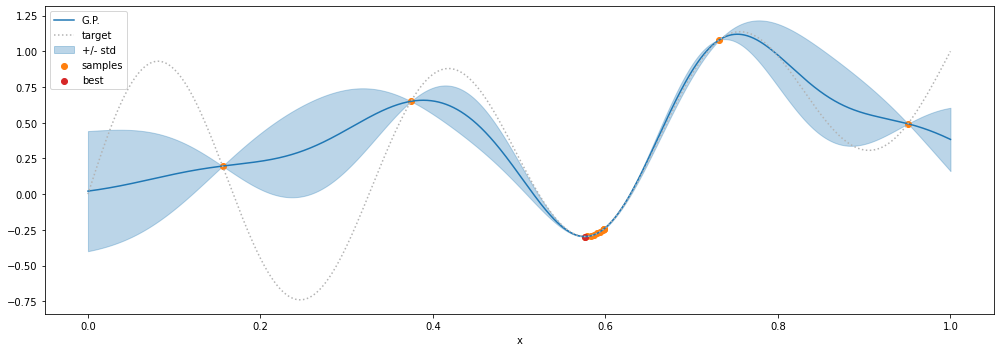

In [5]:
sol, state = util.simple_univariate_BO(f, 0, 1, init_points=5, max_it=10, seed=42, ftype='pi', return_state=True, suppress_warnings=True)
util.plot_series(state['mu'], samples=state['samples'], std=state['std'], target=target, samples2=state['sopt'], samples2_lbl='best', figsize=figsize, xlabel='x', ylabel='G.P.')

* After 10 iterations we reach a local optimum
* ...And we get stuck: this is unfortunately common for $a_{PI}$

## Experiments: Expected Improvement

**Let's try to iterate once using $a_{EI}$ as acquisition function**

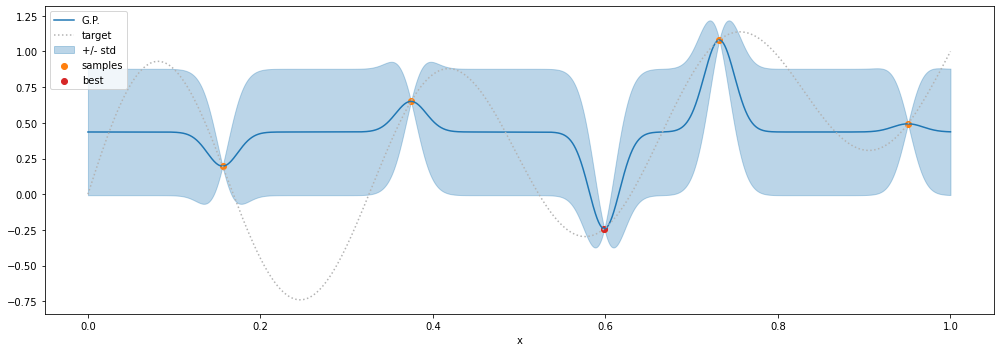

In [6]:
sol, state = util.simple_univariate_BO(f, 0, 1, init_points=5, max_it=1, seed=42, ftype='ei', return_state=True, suppress_warnings=True)
util.plot_series(state['mu'], samples=state['samples'], std=state['std'], target=target, samples2=state['sopt'], samples2_lbl='best', figsize=figsize, xlabel='x', ylabel='G.P.')

* The first point is very similar to that of $a_{PI}$

## Experiments: Expected Improvement

**Let's try to iterate once using $a_{EI}$ as acquisition function**

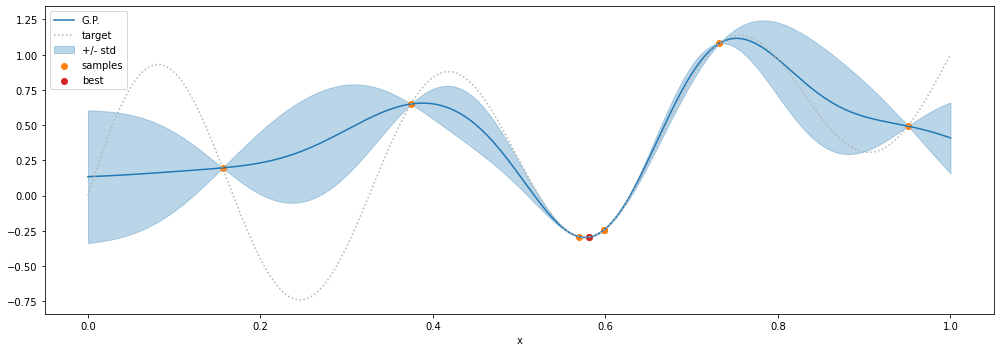

In [7]:
sol, state = util.simple_univariate_BO(f, 0, 1, init_points=5, max_it=5, seed=42, ftype='ei', return_state=True, suppress_warnings=True)
util.plot_series(state['mu'], samples=state['samples'], std=state['std'], target=target, samples2=state['sopt'], samples2_lbl='best', figsize=figsize, xlabel='x', ylabel='G.P.')

* ...But we reach a comparable solution faster (5 vs 10 iterations)

## Experiments: Lower Confidence Bound

**Let's try to iterate once using $a_{LCB}$ as acquisition function**

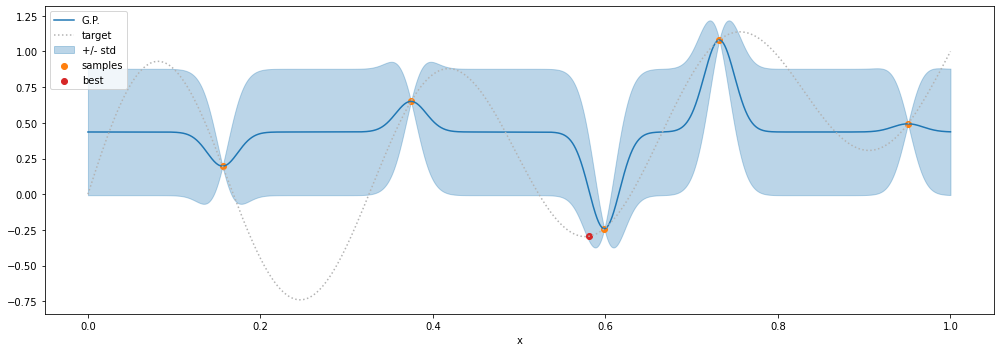

In [8]:
sol, state = util.simple_univariate_BO(f, 0, 1, init_points=5, max_it=1, alpha=0.95, seed=42, ftype='lcb', return_state=True, suppress_warnings=True)
util.plot_series(state['mu'], samples=state['samples'], std=state['std'], target=target, samples2=state['sopt'], samples2_lbl='best', figsize=figsize, xlabel='x', ylabel='G.P.')

* The first point is less close to $y^*$ than $a_{PI}$ and $a_{EI}$
* This is due to the fact that we are _emphasizing exploration_ ($\alpha = 0.95$)

## Experiments: Lower Confidence Bound

**Let's try to iterate once using $a_{LCB}$ as acquisition function**

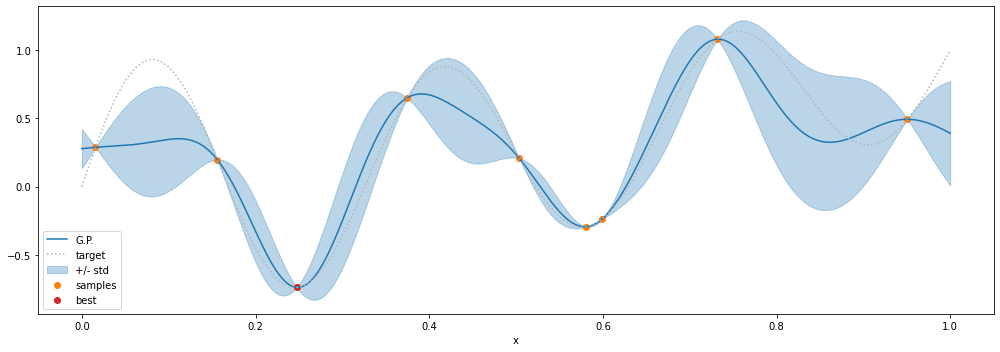

In [10]:
sol, state = util.simple_univariate_BO(f, 0, 1, init_points=5, max_it=5, alpha=0.95, seed=42, ftype='lcb', return_state=True, suppress_warnings=True)
util.plot_series(state['mu'], samples=state['samples'], std=state['std'], target=target, samples2=state['sopt'], samples2_lbl='best', figsize=figsize, xlabel='x', ylabel='G.P.')

* After 5 iterations we have basically found the _global optimum_
* In fact, under some assumptions, $a_{LCB}$ has global convergence guarantees

# Bayesian Optimization for Policy Definition

Back to where we started

## Back to Our Motivating Problem

**We will use BO to tackle our policy definition problem**

$$
\text{argmin}_{\theta} \sum_{k \in K} \mathit{cost}(f(x_k\, \omega^*), 0.5) \\
\text{with: } \omega^* = \text{argmin}_\omega \{ L(y, \mathbb{1}_{\hat{y} \geq \theta}) \mid y = f(x, \omega) \}
$$

We _need_ to optimize over $\theta$

* But since we have now access to a powerful new tool
* ...We will throw in an extra parameter, i.e. _the class weights_

**The reason is that we have an imbalanced dataset**

...But the usual balancing rule _does not_ work well

* Making the classes equally important (i.e. inverse frequencies as weights)
* ...Leads to mistakes early on, and hence to suboptimal policies

## Our Chosen Optimizer

**We will use the [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) python module**

...Which provides a somewhat rough (but fast) implementation of BO

* We start by defining our cost function

```python
def f(thr, c0_weight):
    tr_lbl = (y >= thr) # Labels
    mdl.set_weights(init_wgt)
    sample_weight = np.where(tr_lbl, 1, c0_weight) # Sample weights
    train_ml_model(mdl, X, tr_lbl, epochs=epochs_per_it, # Train
            validation_split=validation_split,
            sample_weight=sample_weight, loss='binary_crossentropy')
    tr_pred = np.round(mdl.predict(X).ravel()) # Predictions
    tr_cost = cmodel.cost(machines, tr_pred, 0.5) # Cost
    return -tr_cost
```

## Our Chosen Optimizer

**We will use the [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) python module**

...Which provides a somewhat rough (but fast) implementation of BO

* Then we specify the bounds for the two parameters

```python
box = {'thr': (0.0, 0.05), 'c0_weight': (1., 5.)}
```

* ...And finally we start the optimization process

```python
res = skopt.gp_minimize(f, [box[k] for k in ('thr', 'c0_weight')],
        acq_func='gp_hedge', n_calls=n_iter, n_random_starts=init_points,
        random_state=seed)
```

* `skopt` relies on a GP with a [Matern Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html) as a surrogate model
* The `gp_hedge` function is a probabilistic combination of $a_{PI}, a_{EI}, a_{LCB}$

## Optimizing the Policy

**Let's use the approach to optimize our policy**

We will use BO to fine-tune the our earlier classifier

In [11]:
nn2 = keras.models.clone_model(nn)
nn2.set_weights(nn.get_weights())
res = util.opt_classifier_policy(nn2, tr_s[dt_in], tr_s['rul'], tr_s['machine'], cmodel=cmodel,
                                 epochs_per_it=3, seed=42, verbose=1)

thr: 0.040, w0: 1.734, cost: -13245, time: 7.81
thr: 0.039, w0: 3.387, cost: -14075, time: 7.87
thr: 0.022, w0: 1.400, cost: -16876, time: 7.83
thr: 0.023, w0: 2.335, cost: -16248, time: 7.71
thr: 0.007, w0: 3.604, cost: -17942, time: 7.79
thr: 0.007, w0: 3.595, cost: -18654, time: 7.71
thr: 0.007, w0: 3.595, cost: -18344, time: 7.71
thr: 0.023, w0: 1.462, cost: -17491, time: 7.65
thr: 0.023, w0: 1.433, cost: -17041, time: 7.75
thr: 0.023, w0: 1.504, cost: -17462, time: 7.86


* Starting from a pre-trained model enables using few epochs per iteration
* The results may vary slighly since training is stochastic

## Optimizing the Policy

**We can inspect the cost values obtained during search**

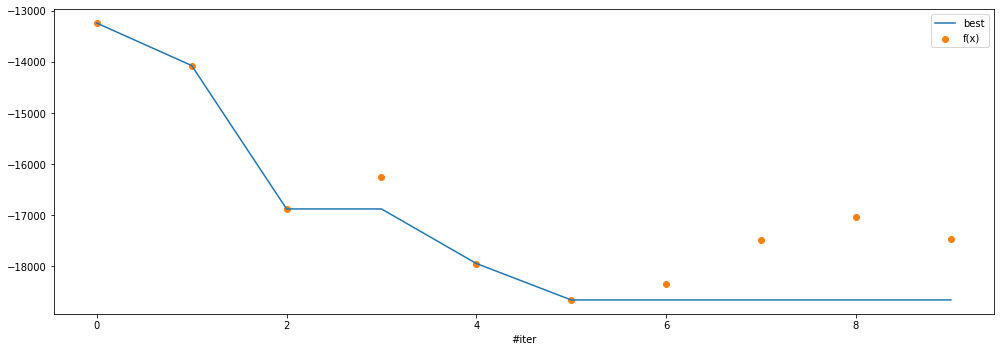

In [12]:
samples = pd.Series(res.func_vals)
best = pd.Series([np.min(samples.iloc[:i]) for i in range(1, len(samples)+1)])
util.plot_series(best, samples=samples, figsize=figsize, xlabel='#iter', ylabel='best', samples_lbl='f(x)')

## Evaluation

**Finally, we can evaluate the optimized model**

In [13]:
tr_pred2 = np.round(nn2.predict(tr_s[dt_in]).ravel())
ts_pred2 = np.round(nn2.predict(ts_s[dt_in]).ravel())
tr_c2, tr_f2, tr_sl2 = cmodel.cost(tr['machine'].values, tr_pred2, 0.5, return_margin=True)
ts_c2, ts_f2, ts_sl2 = cmodel.cost(ts['machine'].values, ts_pred2, 0.5, return_margin=True)
print(f'Cost: {tr_c2} (training), {ts_c2} (test)')
print(f'Avg. fails: {tr_f2/len(tr_mcn)} (training), {ts_f2/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_sl2/len(tr_mcn):.2f} (training), {ts_sl2/len(ts_mcn):.2f} (test)')

Cost: -18654 (training), -6947 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 15.80 (training), 13.54 (test)


The results are significantly better than the old classifier

In [14]:
print(f'Cost: {tr_c} (training), {ts_c} (test)')
print(f'Avg. fails: {tr_f/len(tr_mcn)} (training), {ts_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Cost: -16760 (training), -6356 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 26.31 (training), 23.05 (test)
